# Multisession registration with CaImAn

This notebook will help to demonstrate how to use CaImAn on movies recorded in multiple sessions. CaImAn has in-built functions that align movies from two or more sessions and try to recognize components that are imaged in some or all of these recordings.

The basic function for this is `caiman.base.rois.register_ROIs()`. It takes two sets of spatial components and finds components present in both using an intersection over union metric and the Hungarian algorithm for optimal matching.
`caiman.base.rois.register_multisession()` takes a list of spatial components, aligns sessions 1 and 2, keeps the union of the matched and unmatched components to register it with session 3 and so on.

In [4]:
from IPython import get_ipython
from matplotlib import pyplot as plt
import numpy as np
import pickle

import caiman as cm

from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.utils.utils import download_demo
from caiman.source_extraction.cnmf.cnmf import load_CNMF

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)

num_processors_to_use = None
if 'cluster' in locals():  # 'locals' contains list of current local variables
    print('Closing previous cluster')
    cm.stop_server(dview=cluster)
print("Setting up new cluster")
_, cluster, n_processes = cm.cluster.setup_cluster(backend='multiprocessing', 
                                                 n_processes=num_processors_to_use, 
                                                 ignore_preexisting=False)
print(f"Successfully set up cluster with {n_processes} processes")

Setting up new cluster
Successfully set up cluster with 23 processes


We provide an example file generated from data courtesy of Sue Ann Koay and David Tank (Princeton University). The file contains the spatial footprints derived from the CNMF analysis of the same FOV over six different days, as well as a template (correlation image) for each day. The `download_demo` command will automatically download the file and store it in your caiman_data folder the first time you run it. To use the demo in your own dataset you can set:

```file_path = '/path/to/file'```

or construct a list of spatial footprints and templates and use that to perform the registration as shown below.

In [6]:
load_results = True
num_processors_to_use = None
if load_results:
    save_path =  "C:\\Users\\Moorman\\calcium_imaging\\processed\\IL16-24-086\\2025_05_16\\analyzed_neurons.hdf5"#r'demo_pipeline_cnmfe_results.hdf5'  # or add full/path/to/file.hdf5
    cnmfe_model = load_CNMF(save_path, 
                                n_processes=num_processors_to_use, 
                                dview=cluster)
    correlation_image = cnmfe_model.estimates.Cn
    print(f"Successfully loaded data.")

Successfully loaded data.


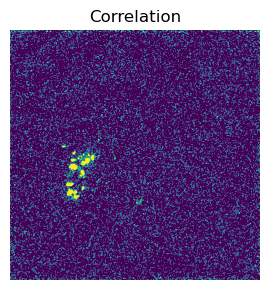

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(correlation_image, 
           cmap='viridis',
           vmin=np.percentile(correlation_image, 50), 
           vmax=np.percentile(correlation_image, 99.5))
plt.title("Correlation", fontsize=12)
plt.axis('off')  # Optional
plt.tight_layout()
plt.show()



In [16]:
load_results = True
num_processors_to_use = None
if load_results:
    save_path =  "C:\\Users\\Moorman\\calcium_imaging\\processed\\IL16-24-086\\2025_05_16\\analyzed_neurons_control.hdf5"#r'demo_pipeline_cnmfe_results.hdf5'  # or add full/path/to/file.hdf5
    cnmfe_model_control = load_CNMF(save_path, 
                                n_processes=num_processors_to_use, 
                                dview=cluster)
    correlation_image_control = cnmfe_model_control.estimates.Cn
    print(f"Successfully loaded data.")

Successfully loaded data.


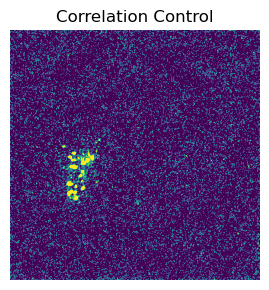

In [17]:
plt.figure(figsize=(3,3))
plt.imshow(correlation_image_control, 
           cmap='viridis',
           vmin=np.percentile(correlation_image_control, 50), 
           vmax=np.percentile(correlation_image_control, 99.5))
plt.title("Correlation Control", fontsize=12)
plt.axis('off')  # Optional
plt.tight_layout()
plt.show()



In [22]:
# Load multisession data (spatial components and mean intensity templates) (should be replaced by actual data)
#file_path = download_demo('alignment.pickle')
#infile = open(file_path,'rb')
#data = pickle.load(infile)
#infile.close()


#spatial = data[0]
#templates = data[1]
#dims = templates[0].shape


spatial = [cnmfe_model.estimates.A, cnmfe_model_control.estimates.A]
templates = [correlation_image, correlation_image_control]
dims = templates[0].shape


In [21]:
templates

[array([[ 0.3333328 ,  0.        ,  0.19980446, ...,  0.44649282,
          0.08094469,  0.1046781 ],
        [ 0.19980049,  0.        ,  0.        , ...,  0.4146511 ,
          0.18303049,  0.28562087],
        [ 0.14103135,  0.        ,  0.21242021, ...,  0.5510779 ,
          0.40214452,  0.32281134],
        ...,
        [ 0.22069307,  0.32803324,  0.5327247 , ...,  0.18169594,
          0.09030999,  0.06371378],
        [ 0.        ,  0.3982574 ,  0.42655358, ...,  0.21579751,
         -0.00223687,  0.14352955],
        [ 0.        ,  0.31565887,  0.11357506, ...,  0.27782455,
          0.2747779 ,  0.23995852]], dtype=float32),
 array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          4.2124134e-01,  2.6643300e-01,  5.3868252e-01],
        [-1.1727110e-03, -9.7449881e-04, -1.2712622e-03, ...,
          2.6316819e-01,  1.7853840e-01,  4.3332377e-01],
        [ 3.8683325e-01,  3.2516119e-01,  3.1150305e-01, ...,
          0.0000000e+00,  0.0000000e+00,  2.7288514e-01]

## Use `register_multisession()`

The function `register_multisession()` requires 3 arguments:
- `A`: A list of ndarrays or scipy.sparse.csc matrices with (# pixels X # component ROIs) for each session
- `dims`: Dimensions of the FOV, needed to restore spatial components to a 2D image
- `templates`: List of ndarray matrices of size `dims`, template image of each session

In [23]:
spatial_union, assignments, matchings = register_multisession(A=spatial, dims=dims, templates=templates)

c:\Users\Moorman\anaconda3\envs\caiman\lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [33]:
np.save("C:\\Users\\Moorman\\calcium_imaging\\processed\\IL16-24-086\\2025_05_16\\assignments.npy", assignments)

In [ ]:
assignments[1,1]
#assignments[merged component #, session #] = session component #

3.0

The function returns 3 variables for further analysis:
- `spatial_union`: csc_matrix (# pixels X # total distinct components), the union of all ROIs across all sessions aligned to the FOV of the last session.
- `assignments`: ndarray (# total distinct components X # sessions). `assignments[i,j]=k` means that component `k` from session `j` has been identified as component `i` from the union of all components, otherwise it takes a `NaN` value. Note that for each `i` there is at least one session index `j` where `assignments[i,j]!=NaN`.
- `matchings`: list of (# sessions) lists. Saves `spatial_union` indices of individual components in each session. `matchings[j][k] = i` means that component `k` from session `j` is represented by component `i` in the union of all components `spatial_union`. In other words `assignments[matchings[j][k], j] = j`.

In [32]:
matchings

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31],
 [32,
  0,
  33,
  1,
  2,
  34,
  3,
  4,
  5,
  35,
  6,
  7,
  8,
  36,
  37,
  38,
  39,
  9,
  10,
  19,
  12,
  15,
  16,
  13,
  17,
  40,
  41,
  18,
  11,
  14,
  23,
  27,
  24,
  42,
  28,
  20,
  43,
  21,
  30,
  29,
  44,
  31,
  45,
  46,
  47]]

## Post-alignment screening

The three outputs can be used to filter components in various ways. For example we can find the components that were active in at least a given a number of sessions. For more examples, check [this script](https://github.com/flatironinstitute/CaImAn/blob/master/use_cases/eLife_scripts/figure_9/Figure_9_alignment.py) that reproduces the results of [Figure 9, as presented in our eLife paper](https://elifesciences.org/articles/38173#fig9).

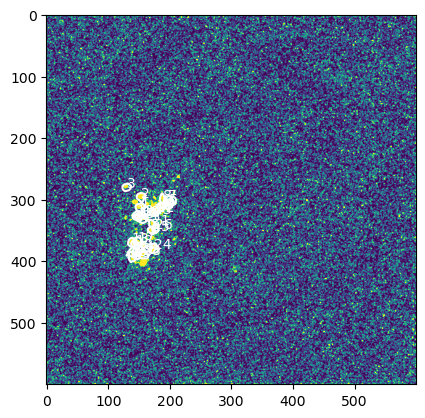

In [24]:
# Filter components by number of sessions the component could be found

n_reg = 2  # minimal number of sessions that each component has to be registered in

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = np.array(np.nan_to_num(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg]), dtype=int);

# Use filtered indices to select the corresponding spatial components
spatial_filtered = spatial[0][:, assignments_filtered[:, 0]]

# Plot spatial components of the selected components on the template of the last session
visualization.plot_contours(spatial_filtered, templates[-1]);

## Combining data of components over multiple sessions (optional)

Now that all sessions are aligned and we have a list of re-registered neurons, we can use `assignments` and `matchings` to collect traces from neurons over different sessions.

As an exercise, we can collect the traces of all neurons that were registered in all sessions. We already gathered the indices of these neurons in the previous cell in `assignments_filtered`. Assuming that traces of each session are saved in their own `CNMF` object collected in a list, we can iterate through `assignments_filtered` and use these indices to find the re-registered neurons in every session.

Note: This notebook does not include the traces of the extracted neurons, only their spatial components. As such the loop below will produce an error if you uncomment it. However, it demonstrates how to use the results of the registration to in your own analysis to extract the traces of the same neurons across different sessions.

In [ ]:
# traces = np.zeros(assignments_filtered.shape, dtype=np.ndarray)
# for i in range(traces.shape[0]):
#     for j in range(traces.shape[1]):
#         traces[i,j] = cnm_list[j].estimates.C[int(assignments_filtered[i,j])]

Now we have the array `traces`, where element `traces[i,j] = k` is the temporal component of neuron `i` at session `j`. This can be performed with `F_dff` data or `S` spikes as well.